# Assignment

In [2]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import toeplitz
import pandas as pd
from tools import export, datafeed
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

pd.set_option('display.precision',4)
plt.rcParams.update({
    'font.size': 16,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [3]:
# Loading up data
data_name = 'USA.xls'

data = datafeed.fetchdata(data_name)
data_mat = datafeed.data_mat(data_name)

In [4]:
datafeed.colname('USA.xls')

['Industrial Production', 'CPI']

## Descriptive statistics and detrending

In [4]:
pd.set_option('display.max_rows',1000)
data.columns = ['IP','CPI']
data.head(5),data.iloc[125:135,:],data.tail(5),

(              IP   CPI
 Year                  
 1919-01-01  24.3  57.6
 1919-02-01  23.9  56.3
 1919-03-01  23.4  57.0
 1919-04-01  23.7  58.0
 1919-05-01  23.9  58.8,
               IP   CPI
 Year                  
 1929-06-01  40.6  59.5
 1929-07-01  39.3  60.1
 1929-08-01  40.0  60.4
 1929-09-01  40.6  60.3
 1929-10-01  39.8  60.3
 1929-11-01  36.1  60.1
 1929-12-01  32.1  59.8
 1930-01-01  33.4  59.6
 1930-02-01  35.1  59.3
 1930-03-01  35.2  59.0,
               IP   CPI
 Year                  
 1939-08-01  36.8  48.1
 1939-09-01  40.5  49.1
 1939-10-01  43.8  48.9
 1939-11-01  44.2  48.8
 1939-12-01  44.1  48.6)

In [5]:
data3 = [data[:'19290501'], data['19290601':], data]
period = ['Pre-GD','GD','1919-1939']

stats= []
for i in range(3):
    sts = data3[i].describe()
    median = pd.DataFrame(data3[i].median()).T
    median = median.rename(index={0: 'median'})
    sts = pd.concat([sts.iloc[:2],median,sts.iloc[2:]]).T
    sts.insert(0,'Period',period[i])
    sts.set_index(['Period',sts.index],inplace=True)
    sts = sts.T
    stats.append(sts)
stats = pd.concat([stats[0],stats[1],stats[2]],axis=1)

stats

Period  Pre-GD              GD         1919-1939        
            IP     CPI      IP     CPI        IP     CPI
count   125.00  125.00  127.00  127.00    252.00  252.00
mean     29.19   61.20   30.69   49.99     29.94   55.55
median   29.90   60.10   29.70   48.70     29.75   58.40
std       5.06    3.29    6.93    4.31      6.11    6.80
min      18.80   56.30   17.60   43.70     17.60   43.70
25%      26.10   59.40   25.50   47.55     25.90   48.70
50%      29.90   60.10   29.70   48.70     29.75   58.40
75%      33.20   61.70   35.50   50.75     33.92   60.20
max      40.80   72.90   44.20   60.40     44.20   72.90

In [81]:
def HPfilter(data, mu):
    data = np.matrix(data.to_numpy()).T
    N = len(data)
    a = mu
    b = -4*mu
    c = 1+6*mu
    f = [[c,b,a]]
    z = [np.zeros(N-3)]
    d = np.concatenate((f,z),axis=1)
    A = toeplitz(d)
    A[:2,:2] = [[1+mu,-2*mu],[-2*mu,1+5*mu]]
    A[-2:,-2:] = np.rot90(A[:2,:2],2)
    trend = inv(A)*data
    cycle = data - trend
    return trend, cycle

output = data.iloc[:,0]
prices = data.iloc[:,1]

Y_trend, Y_cycle = HPfilter(output,129600)

## Time-series Plots

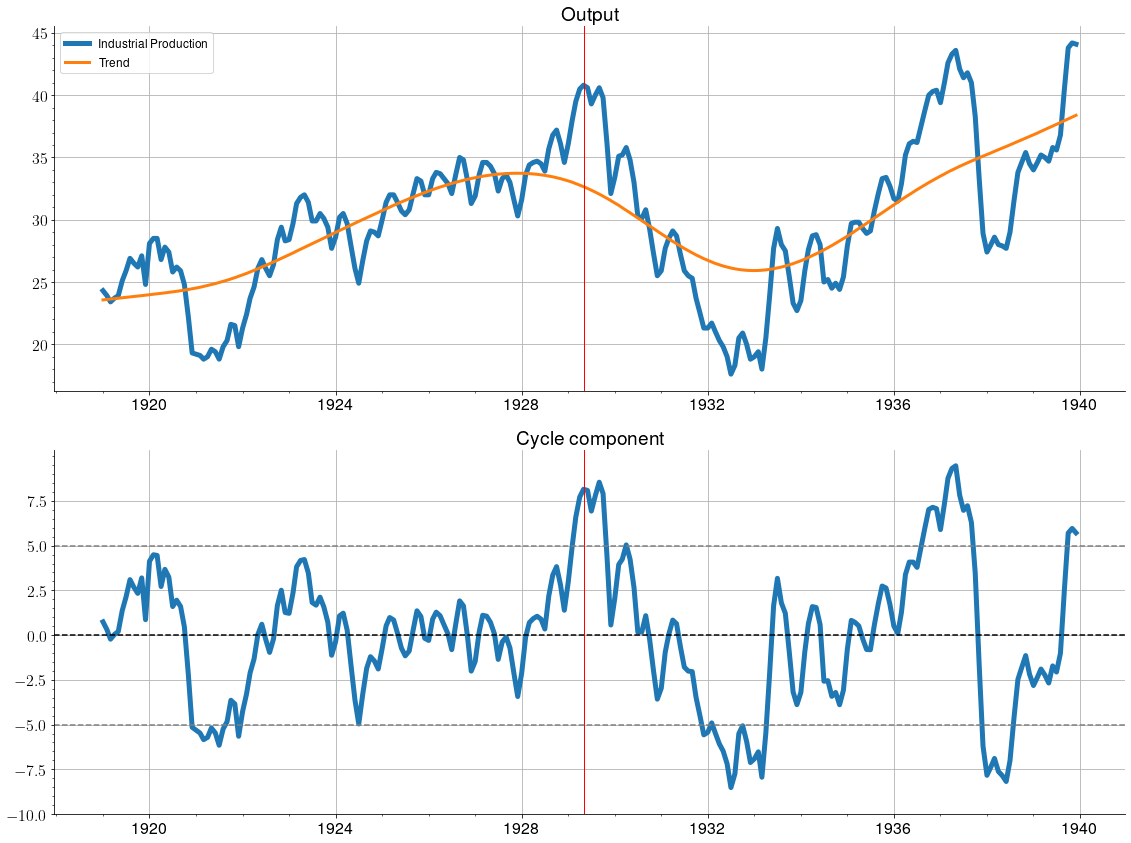

In [86]:
timeHorizon = np.array(data.index)

fig1, ax = plt.subplots(2,1,figsize=(16,12))
ax[0].plot(timeHorizon,output,lw='5')
ax[0].plot(timeHorizon,Y_trend,lw='3')
ax[1].plot(timeHorizon,Y_cycle,lw='5')

ax[1].axhline(y=0,ls='--',c='k')

ax[0].set_title('Output',fontweight='bold')
ax[1].set_title('Cycle component',fontweight='bold')
for i in np.arange(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].axvline('1929-05-01',lw='1',c='r')
ax[0].legend(['Industrial Production','Trend'],
               loc='best',frameon=1,prop={'size': 12})

ax[1].set_yticks(np.arange(-10,10,2.5))
ax[1].axhline(y=-5,ls='--',c='gray')
ax[1].axhline(y=5,ls='--',c='gray')
plt.tight_layout()

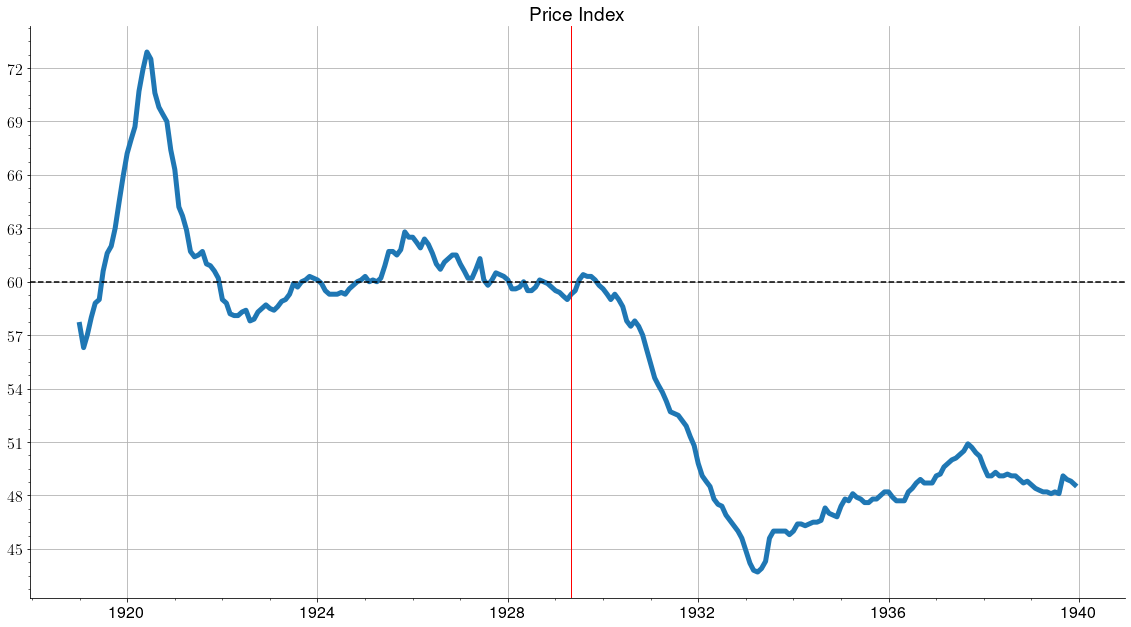

In [8]:
fig2, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(timeHorizon,prices,lw='5')
ax.axhline(y=60,c='k',ls='--')

ax.set_title('Price Index',fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_locator(MultipleLocator(3))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.axvline('1929-05-01',lw='1',c='r')

plt.grid()
plt.tight_layout()

## VAR

In [9]:
# Model parameters (INPUTS)
n = np.size(data_mat,0) # No. of variables
N = np.size(data_mat,1) # No. of observations
p = 12 # Order of VAR
const = 1 # Constant (yes/no)
h = 30 # Forecast horizon

In [10]:

# OLS estimation (Y=A*Z+U)
def VAROLS(data,n,N,p,const):
    Y = data[:,p:]
    # Z matrix
    Z = np.zeros([n*p,N-p])
    for jj in np.arange(N-p):
        Z[:,jj]= np.reshape(np.fliplr(data[:, jj:jj+p]),
                            n*p,order='F')
    Z = np.concatenate((np.ones((const,N-p)),Z),axis=0)
    # OLS estimation: A=(Y*Y')*inv(Z*Z')
    A = np.dot(np.dot(Y,Z.T),inv(np.dot(Z,Z.T)))
    # Variance-covariance matrix
    Sigma = (np.dot(Y,Y.T) - np.dot(A, np.dot(Z,Y.T)))/(N-n*p-const)
    return A, Sigma

# VAR(1) representation: Selection (Xi) and companion matrix (J)
def VAR1(A,n,p,const):
    A = A[:, const:]
    
    eye = np.eye(n*(p-1))
    zeros = np.zeros((n*(p-1),n))
    mat = np.concatenate((eye,zeros),axis=1)
    
    Xi = np.concatenate((A,mat),axis=0)
    
    J = np.concatenate((np.eye(n),
                        np.zeros((n,n*(p-1)))),
                       axis=1)
    return Xi, J

# Blanchard-Quach decomposition
def BlanchardQuach(Xi,J,Sigma):
    # Reduced form long-run multiplier
    B1 = np.dot(np.dot(J,np.linalg.inv(np.identity(n*p)-Xi)),J.T)
    # Structural long-run multiplier
    temp = np.dot(np.dot(B1,Sigma),B1.T)
    # Impact matrix
    C1 = np.linalg.cholesky(temp)
    S = np.dot(np.linalg.inv(B1),C1)
    return S, C1

# Matrices needed
A, Sigma = VAROLS(data_mat,n,N,p,const)
Xi, J = VAR1(A,n,p,const)
S, C1 = BlanchardQuach(Xi,J,Sigma)

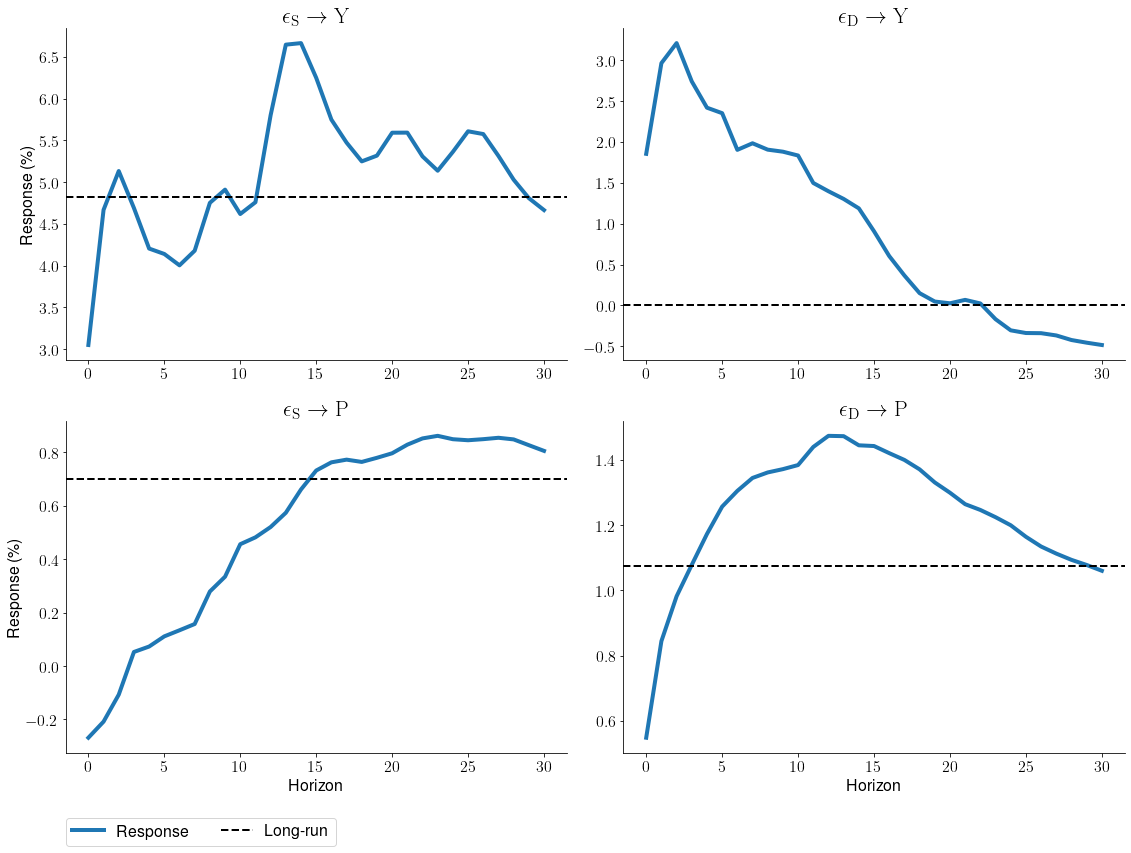

In [40]:
# ---Impulse responses---

epsilon = np.eye(n)
C = np.zeros((h+1,n,n))

for jj in np.arange(h+1):
    temp1 = np.dot(J, np.linalg.matrix_power(Xi,jj))
    temp2 = np.dot(temp1,J.T)
    temp3 = np.dot(temp2, S)
    C[jj:,:,:] = np.dot(temp3,epsilon)
Cs = np.cumsum(C,axis=0)

# Plots of impulse responses

horizon = np.arange(h+1) # x-axis
shock=[r'$\mathrm{\epsilon_S}$',r'$\mathrm{\epsilon_D}$']
response=[r'$\mathrm{Y}$',r'$\mathrm{P}$']

Cs1 = 100*Cs[:,0,0]
Cs2 = 100*Cs[:,0,1]
Cs3 = 100*Cs[:,1,0]
Cs4 = 100*Cs[:,1,1]

fig3, ax = plt.subplots(2,2,figsize=[16,12])

ax[0,0].plot(horizon,Cs1,lw='4')
ax[0,0].axhline(y=100*C1[0,0],c='k',lw='2',ls='--')
ax[0,1].plot(horizon,Cs2,lw='4')
ax[0,1].axhline(y=100*C1[0,1],c='k',lw='2',ls='--')
ax[1,0].plot(horizon,Cs3,lw='4')
ax[1,0].axhline(y=100*C1[1,0],c='k',lw='2',ls='--')
ax[1,1].plot(horizon,Cs4,lw='4')
ax[1,1].axhline(y=100*C1[1,1],c='k',lw='2',ls='--')

for i in np.arange(2):
    ax[1,i].set_xlabel('Horizon')
    ax[i,0].set_ylabel('Response (\%)')
    for j in np.arange(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].set_title(shock[j] + r' $\rightarrow$ ' + response[i],fontsize=22)
ax[1,0].legend(['Response','Long-run'],
               loc='lower left',
               bbox_to_anchor= (0,-0.28),
               ncol=2,borderaxespad=0,frameon=True)
plt.tight_layout()

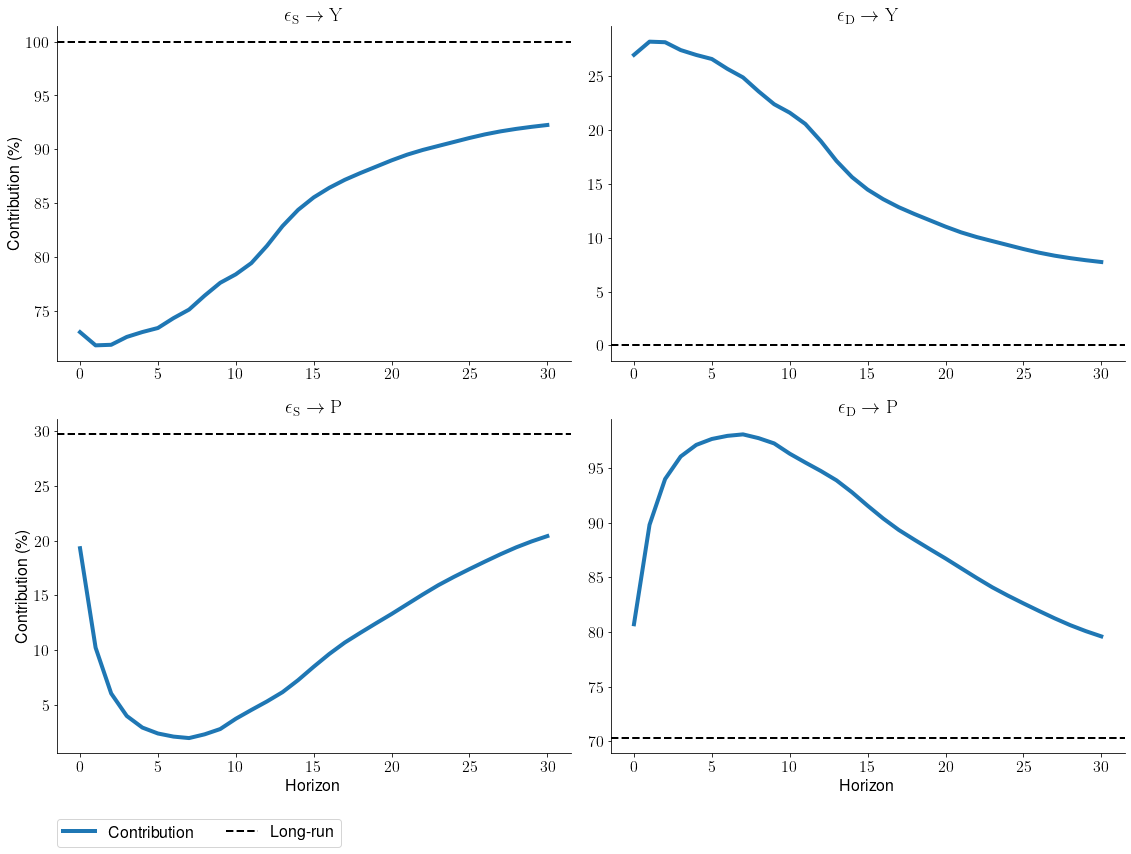

In [36]:
# ---Forcast Error Variance Decomposition---

theta = np.zeros((h+1,n,n))
theta[0,:,:] = (Cs[0,:,:]**2) / np.tile(np.reshape((np.sum(Cs[0,:,:]**2,axis=1)),[n,1]), [1,n])

for jj in np.arange(h):
    # numerator
    theta_numerator = np.sum(Cs[:jj+2,:,:]**2, axis=0)
    # denominator
    d1 = np.transpose(np.sum(Cs[:jj+2,:,:]**2, axis=2))
    d2 = np.transpose(np.array([np.sum(d1, axis=1)]))
    theta_denominator = np.tile(d2, [1,n])
    # final theta
    theta[jj + 1, :, :] = theta_numerator / theta_denominator

# Long-run
theta_long = (C1**2) / np.tile(np.reshape((np.sum(C1**2, axis=1)), [n,1]),[1,n])

# Plots of FEVD
theta1 = 100*theta[:,0,0]
theta2 = 100*theta[:,0,1]
theta3 = 100*theta[:,1,0]
theta4 = 100*theta[:,1,1]

fig4, ax = plt.subplots(2,2,figsize=[16,12])

ax[0,0].plot(horizon,theta1,lw='4')
ax[0,0].axhline(y=100*theta_long[0,0],c='k',lw='2',ls='--')
ax[0,1].plot(horizon,theta2,lw='4')
ax[0,1].axhline(y=100*theta_long[0,1],c='k',lw='2',ls='--')
ax[1,0].plot(horizon,theta3,lw='4')
ax[1,0].axhline(y=100*theta_long[1,0],c='k',lw='2',ls='--')
ax[1,1].plot(horizon,theta4,lw='4')
ax[1,1].axhline(y=100*theta_long[1,1],c='k',lw='2',ls='--')

for i in np.arange(2):
    ax[1,i].set_xlabel('Horizon')
    ax[i,0].set_ylabel('Contribution (\%)')
    for j in np.arange(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].set_title(shock[j] + r' $\rightarrow$ ' + response[i])
ax[1,0].legend(['Contribution','Long-run'],
               loc='lower left',
               bbox_to_anchor= (0,-0.28),
               ncol=2,borderaxespad=0,frameon=True)
plt.tight_layout()

In [35]:
C1_df = pd.DataFrame(C1,index=['Output','Prices'],columns=['Supply','Demand'])*100
C1_df

,Supply,Demand
Output,4.8155,0.0000
Prices,0.6999,1.0764


In [5]:
yearly_data = data.iloc[::12,:]
yearly_data.index = yearly_data.index.strftime('%Y')

In [80]:
def reorder_columns(columns, first_cols=[], last_cols=[], drop_cols=[]):
    columns = list(set(columns) - set(first_cols))
    columns = list(set(columns) - set(drop_cols))
    columns = list(set(columns) - set(last_cols))
    new_order = first_cols + columns + last_cols
    return new_order


pd.set_option('display.precision',1)
yearly_data_pct = yearly_data.pct_change()*100
yearly_data_all = pd.concat([yearly_data,yearly_data_pct],axis=1)
yearly_data_all.columns = ['IP','CPI', 'IP (% change)', 'CPI (% change)']
yearly_data_all = yearly_data_all[reorder_columns(yearly_data_all, ['IP', 'IP (% change)'],['CPI','CPI (% change)'])]

,IP,IP (% change),CPI,CPI (% change)
Year,,,,
1919,24.3,NaN,57.6,NaN
1920,28.1,15.6,67.2,16.7
1921,19.2,-31.7,66.3,-1.3
1922,21.3,10.9,59.0,-11.0
1923,28.4,33.3,58.5,-0.8
1924,28.6,0.7,60.1,2.7
1925,30.0,4.9,60.3,0.3
1926,32.0,6.7,62.5,3.6
1927,31.9,-0.3,61.0,-2.4


,Industrial Production,CPI
Year,,
1919,NaN,NaN
1920,15.6,16.7
1921,-31.7,-1.3
1922,10.9,-11.0
1923,33.3,-0.8
1924,0.7,2.7
1925,4.9,0.3
1926,6.7,3.6
1927,-0.3,-2.4
